In [1]:
set = 'AADO'
balanced = True
passengers = False
trein = False
shallow = False
PCinfo = False
Three = True
dep_var = 'khvm'
k = 2.5

In [2]:
from fastai.tabular.all import *
import torch
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from IPython.display import clear_output, DisplayHandle
import os
from sklearn.utils import resample
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch
# with open('../Odin/OdinData/odin-col-dict.json', "r") as json_file:
#     choice_dict = json.load(json_file)

In [87]:
model_name = set
if passengers == True:
    model_name == '_passengers'
if balanced == True:
    model_name += '_balanced'
if trein == False:
    model_name += '_notrein'
if shallow == True:
    layers = [30, 10, 3]
else:
    layers = [50, 30, 20, 3]
    model_name += '_deep'
if PCinfo == True:
    model_name += 'PCinfo'
if Three == False:
    layers[-1] = 8
    model_name += str(layers[-1])

print(model_name)

All_balanced_notrein_deep


In [88]:
print(layers)

[50, 30, 20, 3]


In [89]:
with open('../Features_Dictionary', "r") as json_file:
    fd = json.load(json_file)
def getcols(fd, KHVM = True, PCInfo = True, Location = True, Weather = True, FelyxKnown = True, OTP = True):
    cols = []
    cols = fd['FelyxKnown']
    if Location == True:
        cols += fd['OTP']
    if Location == True:
        cols += fd['Location']
    cols += fd['Time']
    # # cols += fd['Comparison']
    if PCInfo == True:
        cols += fd['PCInfo']
    if Weather == True:
        cols += fd['Weather']
    if KHVM == True:
        cols += fd['Targets']

    cols = [x for x in cols if x not in ['hvm']]#, 'oprijbewijsau', 'feestdag']]
    return cols
cols = getcols(fd, KHVM = True, Location = False)
cols

['odin_duration',
 'odin_distance',
 'CanFelyx',
 'sin_time',
 'cos_time',
 'weekdag',
 'feestdag',
 'jaar',
 'maand',
 'aank Man',
 'aank Huurwoning',
 'aank Age0',
 'aank Age1',
 'aank hh0',
 'aank hh1',
 'aank build_age0',
 'aank build_age1',
 'aank Immigration0',
 'aank Immigration1',
 'aank size0',
 'aank size1',
 'vert Man',
 'vert Huurwoning',
 'vert Age0',
 'vert Age1',
 'vert hh0',
 'vert hh1',
 'vert build_age0',
 'vert build_age1',
 'vert Immigration0',
 'vert Immigration1',
 'vert size0',
 'vert size1',
 'windspeed',
 'temp',
 'feelslike',
 'precip',
 'precipcover',
 'khvm']

In [3]:
set = 'UrbanAnd'
rawdf = pd.read_pickle('../OdinData/OdinWrangled/Odin2018-2021' + set)
print(len(rawdf))
print(rawdf.head())

56155
               walk_distance  bike_distance  car_distance    pt_distance   
verplid                                                                    
5583798495101            NaN            NaN     114198.39  135172.315543  \
5605137630307            NaN      38962.930      47424.53   46197.044506   
5924436012101            NaN     115442.000     115599.00  108471.000000   
6215831768201            NaN      34114.000      39185.00   38616.000000   
6525830872301      32986.349      33243.951           NaN   38769.187175   

               walk_duration  bike_duration  car_duration  pt_duration   
verplid                                                                  
5583798495101            NaN            NaN        5410.0       6676.0  \
5605137630307            NaN         8536.0        2715.0       3461.0   
5924436012101            NaN        24454.0        5791.0       6083.0   
6215831768201            NaN         7198.0        2502.0       3314.0   
6525830872301    

In [4]:
def age_cat(df):
    age_cuts = [-1, 18, 35, 45, 65] #[-1, 15, 18, 25, 45, 65]
    df['leeftijd_cat'] = df[['leeftijd']].apply(lambda x: pd.cut(x, age_cuts, labels=[str(x) for x in age_cuts[1:]]))
    return df
rawdf = age_cat(rawdf)

In [7]:
target = 'khvm'
otp_cols = ['pt_duration', 'pt_distance', 'car_duration', 'car_distance', 'bike_duration', 'bike_distance', 'walk_distance'] #'distance_moved'
cost_cols = ['AVG_CHARGE', 'car_cost', 'pt_cost_GVB']#'felyx_cost', 'pt_cost'
meteo_cols = ['windspeed', 'temp', 'precip', 'precipcover']
cont_names = otp_cols + cost_cols + meteo_cols
cat_names = ['hour', 'CanFelyx' ,'weekdag']#,#'doel''kmotiefv', 'hhgestinkg'
cat_names += ['leeftijd_cat', 'doel', 'ovstkaart' , 'hhauto' ,'geslacht', 'herkomst', 'opleiding']

# category_cols += ['hhsam', 'hhwelvg', 'hhefiets', 'ovstkaart', 'hhauto', 'hhgestinkg']
# continuous_cols += ['aank Man',
#        'aank Huurwoning', 'aank Age0', 'aank Age1', 'aank hh0', 'aank hh1',
#        'aank build_age0', 'aank build_age1', 'aank Immigration0',
#        'aank Immigration1', 'aank size0', 'aank size1', 'vert Man',
#        'vert Huurwoning', 'vert Age0', 'vert Age1', 'vert hh0', 'vert hh1',
#        'vert build_age0', 'vert build_age1', 'vert Immigration0',
#        'vert Immigration1', 'vert size0', 'vert size1']
df = rawdf[cat_names + cont_names + [target]]
df.head()

,hour,CanFelyx,weekdag,leeftijd_cat,doel,ovstkaart,hhauto,geslacht,herkomst,opleiding,...,bike_distance,walk_distance,AVG_CHARGE,car_cost,pt_cost_GVB,windspeed,temp,precip,precipcover,khvm
verplid,,,,,,,,,,,,,,,,,,,,,
5583798495101,9,0,Dinsdag,18,Diensten/persoonlijke verzorging,Studenten OV-chipkaart met weekabonnement,1,Vrouw,Nederlandse achtergrond,"Middelbaar beroepsonderwijs of havo, atheneum, gymnasium, mms, hbs",...,NaN,NaN,4.6263,38.827453,3.4,13.1,1.0,0.000,0.00,Trein
5605137630307,22,1,Woensdag,65,Visite/logeren,Niet van toepassing; OP jonger dan 15 jaar of 40 jaar of ouder,1,Man,Nederlandse achtergrond,"Hoger beroepsonderwijs, universiteit",...,38962.930,NaN,0.0000,16.124340,3.4,14.9,18.1,32.130,29.17,Personenauto - bestuurder
5924436012101,11,1,Vrijdag,65,Overige vrijetijdsbesteding,Niet van toepassing; OP jonger dan 15 jaar of 40 jaar of ouder,2,Man,Westerse migratieachtergrond,"Hoger beroepsonderwijs, universiteit",...,115442.000,NaN,4.3803,39.303660,3.4,17.8,5.9,0.580,25.00,Personenauto - passagier
6215831768201,7,1,Vrijdag,65,Werken,Niet van toepassing; OP jonger dan 15 jaar of 40 jaar of ouder,1,Vrouw,Nederlandse achtergrond,"Hoger beroepsonderwijs, universiteit",...,34114.000,NaN,1.6000,13.322900,3.4,25.6,17.3,1.296,20.83,Trein
6525830872301,12,1,Dinsdag,35,Onderwijs/cursus volgen,Studenten OV-chipkaart met weekabonnement,1,Man,Nederlandse achtergrond,"Middelbaar beroepsonderwijs of havo, atheneum, gymnasium, mms, hbs",...,33243.951,32986.349,1.6000,NaN,3.4,15.2,13.1,2.946,29.17,Trein


In [8]:
df = rawdf
if trein == False:
    df[dep_var] = df[dep_var].replace('Trein', 'Bus/tram/metro')
df[dep_var].unique()

df[dep_var].replace('Personenauto - passagier', 'Personenauto - bestuurder', inplace = True)
print(len(df))

df = df[df[dep_var] != 'Overig']

56155


In [9]:
def balance_multiclass(df, target_col, k):
    # Find out which class has the most entries
    max_size = df[target_col].value_counts().min()

    dfs = []

    for class_name, group in df.groupby(target_col):
        # For each group, randomly oversample with replacement to the size of the largest group
        df_group_resampled = resample(group, replace=True, n_samples= max(int(max_size * k), len(group)), random_state=123)
        dfs.append(df_group_resampled)

    # Concatenate all groups and return
    return pd.concat(dfs, axis=0)
if balanced == True:
    df = balance_multiclass(df, 'khvm', k=k)

len(df)

73068

In [10]:
dep_var = 'khvm'
# cat_names = list(df.select_dtypes(include=['object']).columns)
# cont_names = [x for x in cols if x not in cat_names]
# cat_names.remove(dep_var)

procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=procs, cat_names=cat_names,
                   cont_names=cont_names, y_names=dep_var,
                   splits = splits, y_block = CategoryBlock())
dls = to.dataloaders(bs=64, splits=splits)
# learn = tabular_learner(dls, layers=layers, metrics=accuracy)
learn = tabular_learner(dls, metrics=accuracy, layers = [50, 20, 3])

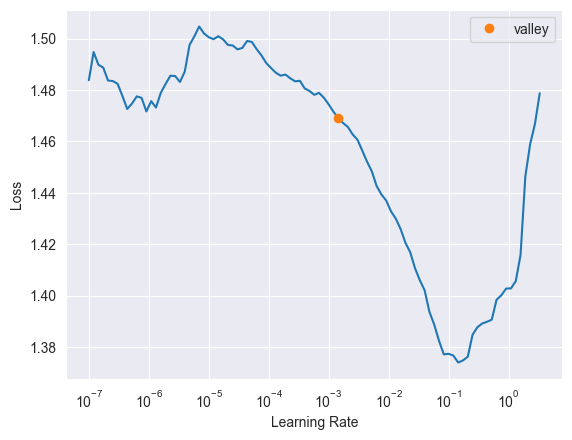

In [11]:
lr = learn.lr_find()

In [12]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.004105,0.993917,0.000000,00:47


In [37]:
os.makedirs(os.path.join('models', model_name), exist_ok = True)
learn.export(os.path.join('models', model_name, 'model.pkl'))
# learn = load_learner(os.path.join('ModelNames', model_name, 'model.pkl'))

NameError: name 'model_name' is not defined

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

                           precision    recall  f1-score   support

           Bus/tram/metro       0.65      0.58      0.61      3250
                    Fiets       0.52      0.52      0.52      4483
Personenauto - bestuurder       0.55      0.64      0.59      3657
                  Te voet       0.59      0.56      0.57      3223

                 accuracy                           0.57     14613
                macro avg       0.58      0.57      0.57     14613
             weighted avg       0.57      0.57      0.57     14613



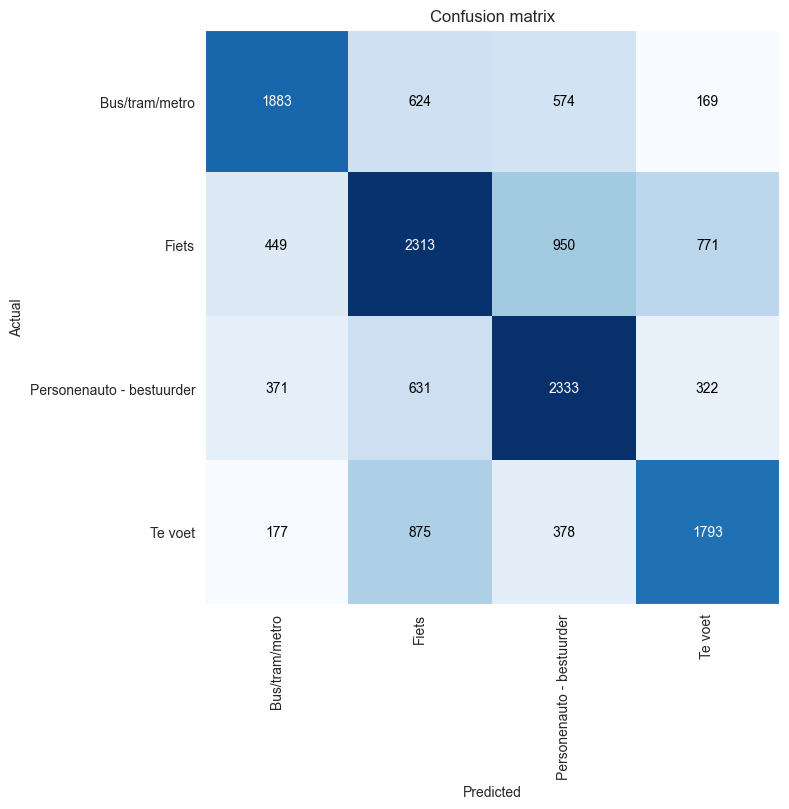

In [14]:
interp.plot_confusion_matrix(figsize=(8,8))

In [27]:
test_df = pd.read_pickle('../FelyxData/FelyxModellingData/felyxotpAADO')
test_df.columns


test_cols = [col for col in df.columns if col != dep_var]
test_df = test_df[test_cols]

KeyError: "['odin_duration', 'odin_distance', 'oprijbewijsmo', 'oprijbewijsau', 'geslacht', 'leeftijd', 'herkomst', 'opleiding', 'doel', 'kmotiefv', 'hhgestinkg', 'hhauto', 'jaar', 'maand', 'hhsam', 'hhwelvg', 'hhefiets', 'ovstkaart', 'aank Man', 'aank Huurwoning', 'aank Age0', 'aank Age1', 'aank hh0', 'aank hh1', 'aank build_age0', 'aank build_age1', 'aank Immigration0', 'aank Immigration1', 'aank size0', 'aank size1', 'vert Man', 'vert Huurwoning', 'vert Age0', 'vert Age1', 'vert hh0', 'vert hh1', 'vert build_age0', 'vert build_age1', 'vert Immigration0', 'vert Immigration1', 'vert size0', 'vert size1', 'hour'] not in index"

In [77]:
dl = learn.dls.test_dl(test_df)
#
preds, _ = learn.get_preds(dl=dl)#, with_decoded=True)
preds = preds.argmax(dim=-1)
test_df['pred'] = [dl.vocab[pred] for pred in preds]
test_df.groupby('pred').count()

,odin_duration,odin_distance,CanFelyx,walk_distance,bike_distance,car_distance,pt_distance,walk_duration,bike_duration,car_duration,...,vert build_age1,vert Immigration0,vert Immigration1,vert size0,vert size1,windspeed,temp,feelslike,precip,precipcover
pred,,,,,,,,,,,,,,,,,,,,,
Bus/tram/metro,728,728,728,728,728,728,728,728,728,728,...,728,728,728,728,728,728,728,728,728,728
Fiets,14097,14097,14097,14097,14097,14097,14097,14097,14097,14097,...,14097,14097,14097,14097,14097,14097,14097,14097,14097,14097
Personenauto - bestuurder,293,293,293,293,293,293,293,293,293,293,...,293,293,293,293,293,293,293,293,293,293
Personenauto - passagier,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68
Te voet,3279,3279,3279,3279,3279,3279,3279,3279,3279,3279,...,3279,3279,3279,3279,3279,3279,3279,3279,3279,3279


In [ ]:
# dl = learn.dls.test_dl(df)
#
# preds, _ = learn.get_preds(dl=dl)#, with_decoded=True)
# preds = preds.argmax(dim=-1)
# df['pred'] = [dl.vocab[pred] for pred in preds]
# df.groupby('pred').count()

In [78]:
learn.model.layers

Sequential(
  (0): LinBnDrop(
    (0): Linear(in_features=364, out_features=50, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): LinBnDrop(
    (0): Linear(in_features=50, out_features=30, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): LinBnDrop(
    (0): Linear(in_features=30, out_features=20, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): LinBnDrop(
    (0): Linear(in_features=20, out_features=3, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): LinBnDrop(
    (0): Linear(in_features=3, out_features=5, bias=True)
  )
)

In [15]:
# Pass the test DataLoader through the trained model
hook = hook_output(learn.model.layers[-2])

hactslist = []

# for i in [df, test_df]:
for i in [df]:
    print(i.head())
    dl = learn.dls.test_dl(i)

    all = []

    for batch in dl:
        # print(batch)
        b = (batch[0].to('mps:0'), batch[1].to('mps:0'))
        with torch.no_grad():
            learn.model.eval()
            _ = learn.model(*b)

        activations = hook.stored
        all.append(activations)

    hacts = np.concatenate([a.cpu() for a in all], axis=0)
    hactslist.append(hacts)

combinedhacts = np.concatenate(hactslist)
combinedhacts.shape

               walk_distance  bike_distance  car_distance  pt_distance   
verplid                                                                  
5900603317502       1973.000       2092.000      3701.000  2174.000000  \
6216487377901       6972.000      10101.000           NaN          NaN   
6525819117102       8456.392       8556.138      8599.113  8946.190595   
5590250267802       2995.670       3172.770      3770.830  3797.579312   
6207200438201       5979.000       6042.000      6303.000  6966.000000   

               walk_duration  bike_duration  car_duration  pt_duration   
verplid                                                                  
5900603317502         1557.0          476.0         693.0        722.0  \
6216487377901         5425.0         2396.0           NaN          NaN   
6525819117102         6754.0         1990.0        1403.0       2412.0   
5590250267802         2436.0          801.0         735.0       1508.0   
6207200438201         4726.0         

(73068, 3)

In [16]:
n_components = 3
# df = df.drop(['Emb0'], axis = 1)
df[['Emb' + str(i) for i in range(n_components)]] = combinedhacts#np.concatenate([trainhacts, testhacts])

In [17]:
df.columns

Index(['walk_distance', 'bike_distance', 'car_distance', 'pt_distance',
       'walk_duration', 'bike_duration', 'car_duration', 'pt_duration',
       'odin_duration', 'odin_distance', 'oprijbewijsmo', 'oprijbewijsau',
       'geslacht', 'leeftijd', 'herkomst', 'opleiding', 'doel', 'kmotiefv',
       'hhgestinkg', 'hhauto', 'vertpc', 'aankpc', 'weekdag', 'feestdag',
       'jaar', 'maand', 'hvm', 'khvm', 'windspeed', 'temp', 'feelslike',
       'precip', 'precipcover', 'hhsam', 'hhwelvg', 'hhefiets', 'ovstkaart',
       'CanFelyx', 'prev_time', 'AVG_CHARGE', 'distance_moved', 'aank Man',
       'aank Huurwoning', 'aank Age0', 'aank Age1', 'aank hh0', 'aank hh1',
       'aank build_age0', 'aank build_age1', 'aank Immigration0',
       'aank Immigration1', 'aank size0', 'aank size1', 'vert Man',
       'vert Huurwoning', 'vert Age0', 'vert Age1', 'vert hh0', 'vert hh1',
       'vert build_age0', 'vert build_age1', 'vert Immigration0',
       'vert Immigration1', 'vert size0', 'vert size1

In [18]:
df.to_pickle('embs')
df.head()

,walk_distance,bike_distance,car_distance,pt_distance,walk_duration,bike_duration,car_duration,pt_duration,odin_duration,odin_distance,...,time_category,hour,felyx_cost,pt_cost,car_cost,pt_cost_GVB,leeftijd_cat,Emb0,Emb1,Emb2
verplid,,,,,,,,,,,,,,,,,,,,,
5900603317502,1973.000,2092.000,3701.000,2174.000000,1557.0,476.0,693.0,722.0,1200.0,3300.0,...,Daytime,15,4.8115,1.238220,1.258340,1.428442,35,1.497282,0.703124,0.773233
6216487377901,6972.000,10101.000,NaN,NaN,5425.0,2396.0,NaN,NaN,1740.0,6100.0,...,Morning,8,25.0000,1.695417,NaN,2.001034,45,-1.550762,0.803112,0.400212
6525819117102,8456.392,8556.138,8599.113,8946.190595,6754.0,1990.0,1403.0,2412.0,2100.0,12000.0,...,Daytime,15,8.7165,2.083557,2.923698,2.487139,NaN,-0.439052,2.117539,1.665148
5590250267802,2995.670,3172.770,3770.830,3797.579312,2436.0,801.0,735.0,1508.0,1800.0,5500.0,...,Daytime,10,5.0425,1.332892,1.282082,1.547009,45,1.032240,1.201597,0.380704
6207200438201,5979.000,6042.000,6303.000,6966.000000,4726.0,1401.0,1229.0,2453.0,1800.0,7600.0,...,Daytime,9,7.7595,1.813707,2.143020,2.149180,35,-1.227441,1.539943,0.604208


In [30]:
n_components = 3
# combined = pd.concat([df, test_df])
combined = pd.concat([df])
# combined['train'] = (([1] * len(df))   )#+ ([0] * len(test_df)))
# combined['choice'] = pd.concat([combined[combined.khvm.notnull()].khvm, combined[combined.train == 0].pred])

combined[['Emb' + str(i) for i in range(n_components)]] = combinedhacts#np.concatenate([trainhacts, testhacts])

# os.makedirs(os.path.join('models', model_name), exist_ok = True)
# combined.to_pickle(os.path.join('models', model_name, 'predictions'))
combined.to_pickle('embs')
combined.head()

ValueError: Columns must be same length as key

In [81]:
embedding_matrices = [embed.weight.cpu().detach().numpy() for embed in learn.model.embeds]
category_names = [k for k, v in learn.dls.classes.items()]
indices = [learn.dls.classes[categ] for categ in learn.dls.classes.keys()]
categ_dictionary = dict(zip(category_names, [pd.DataFrame(data = em, index = i) for i, em in zip(indices,embedding_matrices)]))

with open(os.path.join('models', model_name, 'embedding_dictionary'), 'wb') as f:
    pickle.dump(categ_dictionary, f)

print(categ_dictionary.keys())

dict_keys(['vertpc', 'aankpc', 'weekdag', 'feestdag', 'jaar', 'maand'])


In [ ]:
n_components = 3
pca = PCA(n_components=n_components)
redu = pca.fit_transform(np.concatenate([trainhacts, testhacts]))

combined[['PCA' + str(i) for i in range(n_components)]] = redu

In [56]:
# show = combined[combined.train == 1].sample(100)
combined = pd.concat([combined[combined.train == x].sample(5000) for x in [0,1]])

In [57]:
show = pd.concat([combined[combined.choice == x].sample(20) for x in combined.choice.unique()])

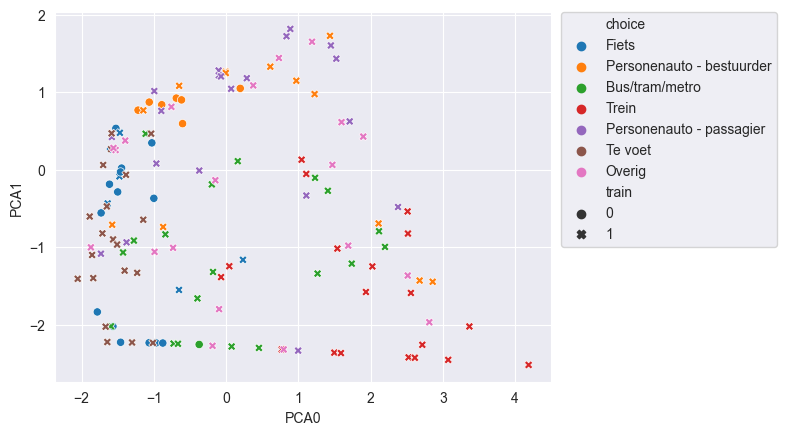

In [52]:
#2D option
sns.scatterplot(data = show, x = 'PCA0', y= 'PCA1', hue = 'choice', style = 'train')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_9739/1045855428.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(show['choice'].unique()))


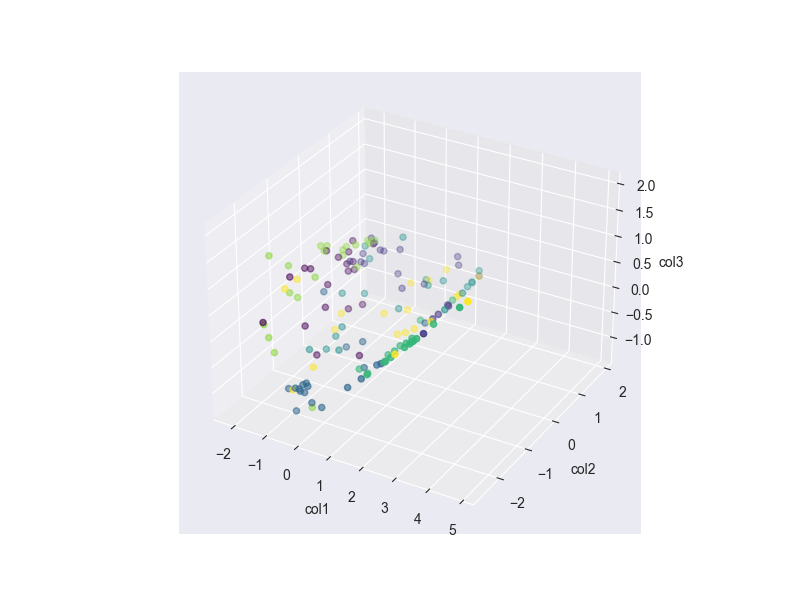

In [76]:
#3D Option
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm
colormap = cm.get_cmap('viridis', len(show['choice'].unique()))
color_dict = {category: colormap(i) for i, category in enumerate(show['choice'].unique())}

ax.scatter(show['PCA0'], show['PCA1'], show['PCA2'], c=show.choice.map(color_dict), marker='o')

ax.set_xlabel('col1')
ax.set_ylabel('col2')
ax.set_zlabel('col3')
plt.show()

In [48]:
#Create a Dicitonary containing the embedding matrix for every categorical variable
embedding_matrices = [embed.weight.cpu().detach().numpy() for embed in learn.model.embeds]
category_names = [k for k, v in learn.dls.classes.items()]
indices = [learn.dls.classes[categ] for categ in learn.dls.classes.keys()]
categ_dictionary = dict(zip(category_names, embedding_matrices))
for i in categ_dictionary.keys():
    print(i, ': ', categ_dictionary[i].shape)

vertpc :  (1477, 95)
aankpc :  (1460, 95)
weekdag :  (8, 5)
hour :  (25, 10)


/Users/joshuathomas/PycharmProjects/EmbeddedMobility/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


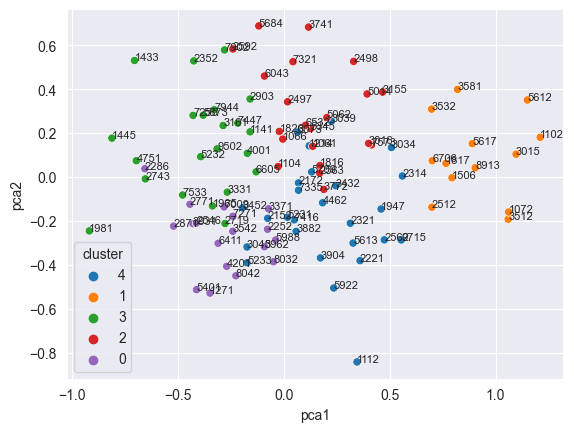

In [45]:
lablength = 10
categ = 'aankpc'
embedding_matrix = categ_dictionary[categ]
labels = learn.dls.classes[categ]

k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding_matrix)
# Give it the category name if the info is in the JSON
if categ in choice_dict.keys():
    labels = [choice_dict[categ].get(item, item)[:lablength] for item in [str(lab) for lab in labels]]
else:
    labels = [str(lab)[:lablength] for lab in labels]
pca = PCA(n_components=2)
mat_2d = pca.fit_transform(embedding_matrix)

PlotData = pd.DataFrame({'pca1': mat_2d[1:, 0], 'pca2': mat_2d[1:, 1],
                       categ: labels[1:], 'cluster':[str(x) for x in kmeans.labels_[1:]]})

if len(PlotData) > 100:
    PlotData = PlotData.sample(100)

sns.scatterplot(data = PlotData, x = 'pca1', y = 'pca2', hue = 'cluster')

for i in PlotData.index:
    plt.text(PlotData.pca1.loc[i], PlotData.pca2.loc[i], PlotData[categ][i], fontsize=8)